/home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Feb  1 2023 20:12:59


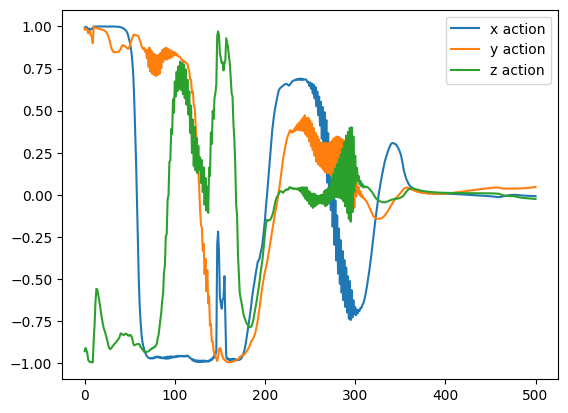

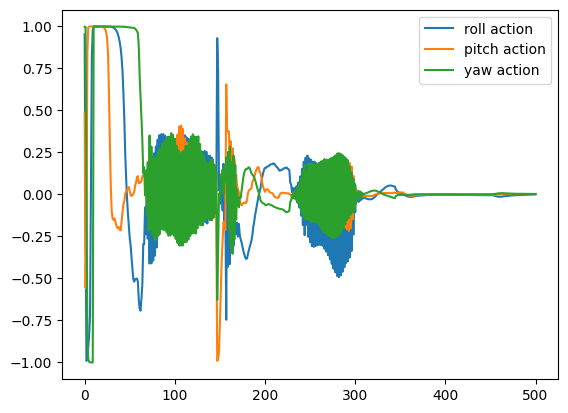

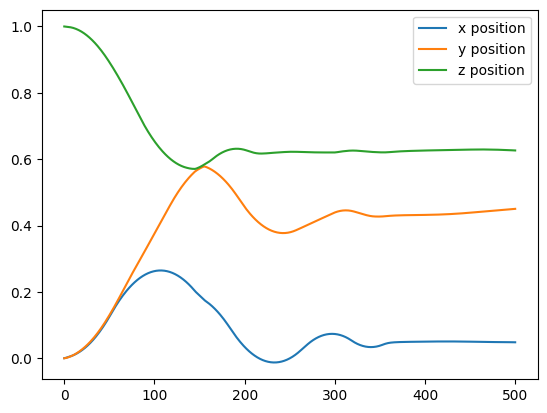

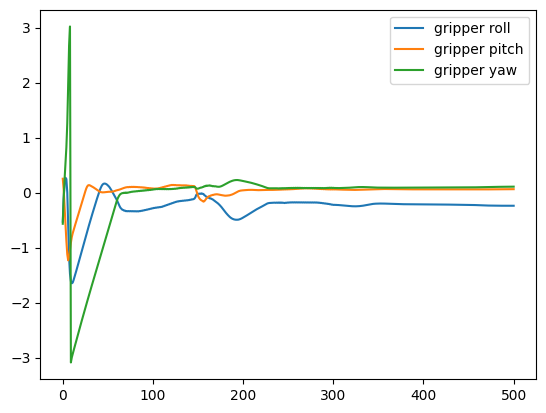

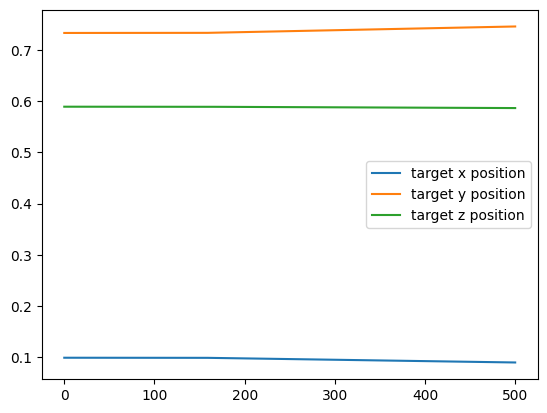

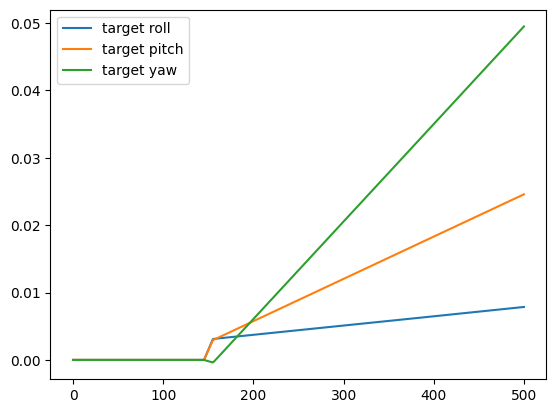

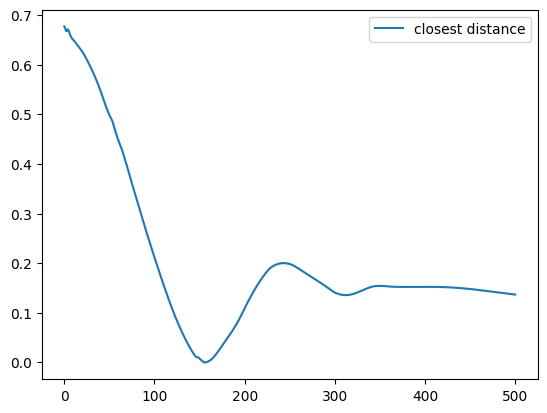

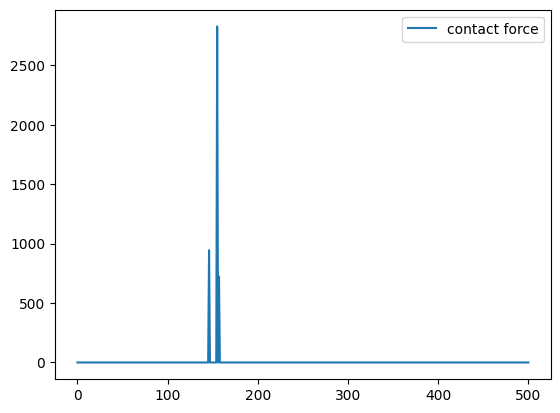

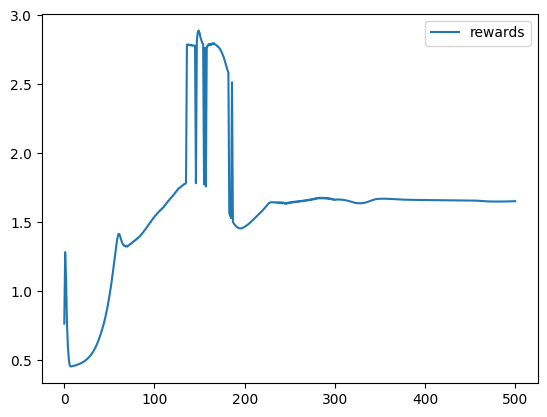

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import gym
import pybullet as p
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from new import robotiqGymEnv

def load_model(file_path):
    """
    Load the model from the given file path
    """
    return SAC.load(file_path)

def extract_data(env, model, obs, steps):
    """
    Run the model prediction and extract data into arrays
    """
    position_action_data = []
    angle_action_data = []
    gripper_position_data = []
    gripper_angle_data = []
    target_position_data = []
    target_angle_data = []
    closest_point_data = []
    contact_force_data = []
    rewards_data = []
    done = False

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info = env.step(action)

        base_pos, base_orientation = p.getBasePositionAndOrientation(env._robotiq.robotiq_uid)
        target_pos, target_orientation = p.getBasePositionAndOrientation(env.blockUid)

        gripper_angle = p.getEulerFromQuaternion(base_orientation)
        target_angle = p.getEulerFromQuaternion(target_orientation)

        position_action_data.append(action[0:3])
        angle_action_data.append(action[3:6])
        gripper_position_data.append(base_pos)
        gripper_angle_data.append(gripper_angle)
        target_position_data.append(target_pos)
        target_angle_data.append(target_angle)
        closest_point_data.append(p.getClosestPoints(env._robotiq.robotiq_uid, env.blockUid, 100, -1, -1)[0][8])
        contact_force_data.append(env._contactinfo()[4])
        rewards_data.append(rewards)
        # print size position_data
        # print(len(position_data))
        # print(len(position_data[0]))
    return position_action_data, angle_action_data, gripper_position_data, gripper_angle_data, target_position_data, target_angle_data, closest_point_data, contact_force_data, rewards_data

def plot_data(data, labels):
    """
    Plot the data using matplotlib
    """
    plt.figure()
    for d, label in zip(data, labels):
        plt.plot(d, label=label)
        plt.legend()



def main():
    """
    Main function to run the program
    """
    model_file = "models/20230316-03:42PM_SAC_M10000_0.04_39/best_model.zip"
    model = load_model(model_file)

    with robotiqGymEnv(records=False, renders=False) as env:
        obs = env.reset()
        steps = range(500) # define the number of steps here
        position_action_data, angle_action_data, gripper_position_data, gripper_angle_data, target_position_data, target_angle_data, closest_point_data, contact_force_data, rewards_data = extract_data(env, model, obs, steps)

    plot_data(zip(*position_action_data), ["x action", "y action", "z action"])
    plot_data(zip(*angle_action_data), ["roll action", "pitch action", "yaw action"])
    plot_data(zip(*gripper_position_data), ["x position", "y position", "z position"])
    plot_data(zip(*gripper_angle_data), ["gripper roll", "gripper pitch", "gripper yaw"])
    plot_data(zip(*target_position_data), ["target x position", "target y position", "target z position"])
    plot_data(zip(*target_angle_data), ["target roll", "target pitch", "target yaw"])
    plot_data([closest_point_data], ["closest distance"])
    plot_data([contact_force_data], ["contact force"])
    plot_data([rewards_data], ["rewards"])


if __name__ == "__main__":
    main()
